In [1]:
import os, sys

sys.path.insert(0, os.path.abspath('..'))
os.environ['USE_PYGEOS'] = '0'

%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import pandas as pd
from shapely.geometry import shape
from shapely.geometry import Polygon
import uuid
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [84]:
def generate_fishnet(polygon, x, y, crs = 'EPSG:4326'):
    print("Generating Fishnet!", datetime.now())
    # Get the bounding box of the polygon
    minx, miny, maxx, maxy = polygon.bounds

    # Generate arrays of x and y coordinates for the fishnet
    x_coords = np.arange(minx, maxx + x, x)
    y_coords = np.arange(miny, maxy + y, y)

    # Create a list to store the individual grid cells
    cells = []

    # Iterate through x and y coordinates to create grid cells
    for i in range(len(x_coords) - 1):
        for j in range(len(y_coords) - 1):
            cell = Polygon([
                (x_coords[i], y_coords[j]),
                (x_coords[i + 1], y_coords[j]),
                (x_coords[i + 1], y_coords[j + 1]),
                (x_coords[i], y_coords[j + 1]),
            ])
            # Check if the cell intersects with the polygon
            if cell.intersects(polygon):
                # If yes, add it to the list of cells
                cells.append(cell)

    # Create a GeoDataFrame with the grid cells
    fishnet = gpd.GeoDataFrame(geometry=cells, crs=crs)
    print("Complete!", datetime.now())
    return fishnet


def optimal_smooth_fishnet(fishnet, 
                          min_length, 
                          min_height, 
                          max_area):
    """
    Given a Fishnet grid, combine cells to generate a new polygon (square or rectangle), such that 
    polygon has 
    1) length at least MIN_LENGTH
    2) height at least MIN_HEIGHT
    3) area at least MAX_AREA
    
    """
    print("Merging!", datetime.now())
    cells = []
    polygons = []
    
    add_geom = True
    last_polygon= None
    cell_add = True
    geoms = fishnet_grid.geometry.values

    new_minx, new_miny, _, _ =  fishnet_grid.total_bounds


    for geom in geoms:
        geom_centroid = geom.centroid
        geom_minx, geom_miny, geom_maxx, geom_maxy = geom.bounds
        if (last_polygon is not None) & (geom_centroid.within(last_polygon)):
            cell_add = False
        else:
            cell_add = True

        if len(cells) > 0:

            tmp = gpd.GeoDataFrame(geometry = cells)
            minx, miny, maxx, maxy = tmp.total_bounds

            l = (maxx - minx)
            w = (maxy - miny)
            area =  l * w

            if (area > max_area) & (l > min_length) & ( w > min_height):
                polygon = Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny)])
                polygons.append(polygon)
                last_polygon  = polygon
                new_minx = maxx
                new_miny = maxy
                add_geom = False
                cells = []

        if (add_geom) & (cell_add):
            cells.append(geom)

        if len(cells) == 0:
            add_geom = True
            
    print("Complete!", datetime.now())
    return polygons

In [76]:
#### PARAMS

## Fishnet (in meters)

CELL_SIZE = 500


# MAX_LENGTH = 5000
MIN_LENGTH = 3000
# MAX_HEIGHT = 5000
MIN_HEIGHT = 3000

MAX_AREA_KM = 25
MAX_AREA = MAX_AREA_KM * 1e6

In [83]:
#### Load files
sone = gpd.read_file("/data/sand_mining/rivers/sone_polygon.geojson")

### Convert to UTM
sone_utm = sone.to_crs(sone.estimate_utm_crs())

# Generate the fishnet grid
cw = CELL_SIZE
ch = CELL_SIZE
fishnet_grid = generate_fishnet(sone_utm.geometry.values[0], cw, ch, crs = sone.estimate_utm_crs())


Generating Fishnet! 2023-12-12 00:56:55.765191
Complete! 2023-12-12 00:57:18.331969


In [85]:
### Get Optimal Polygons various areas
polygons_10km2 = optimal_smooth_fishnet(fishnet_grid, 3000, 3000, 10*1e6)
polygons_25km2 = optimal_smooth_fishnet(fishnet_grid, 3000, 3000, 25*1e6)
polygons_50km2 = optimal_smooth_fishnet(fishnet_grid, 3000, 3000, 50*1e6)

Merging! 2023-12-12 00:59:53.595523
Complete! 2023-12-12 00:59:57.912471
Merging! 2023-12-12 00:59:57.912633
Complete! 2023-12-12 01:00:02.261299
Merging! 2023-12-12 01:00:02.261471
Complete! 2023-12-12 01:00:06.882653


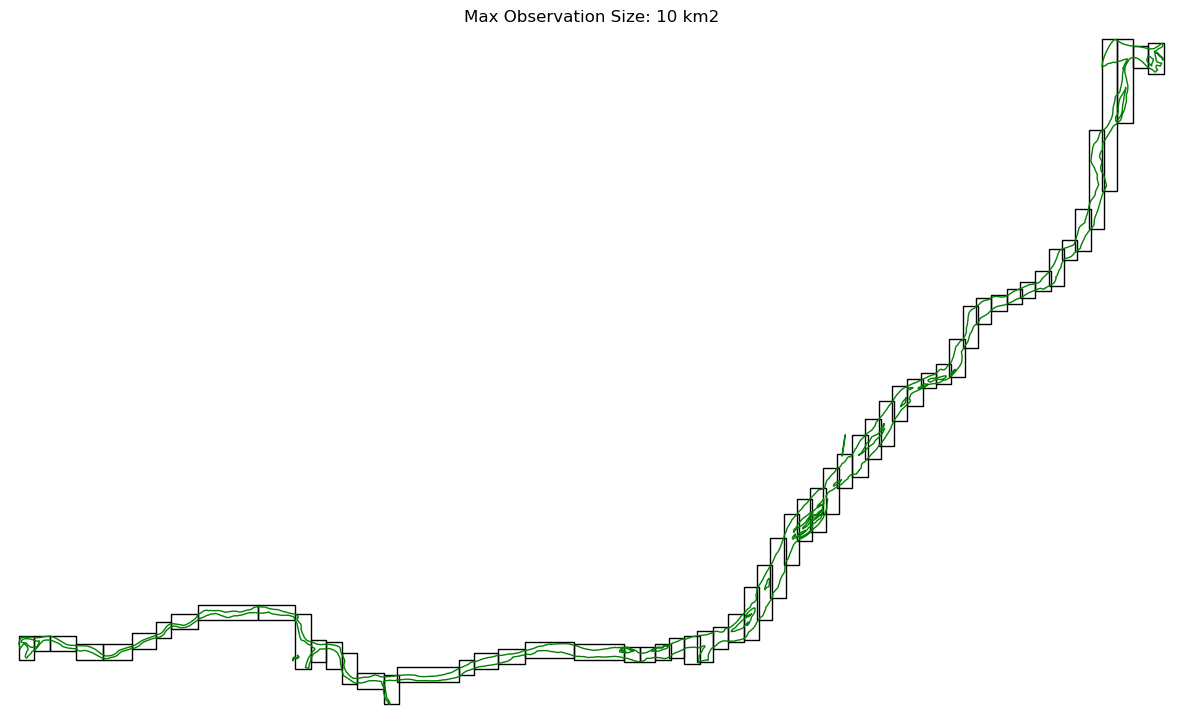

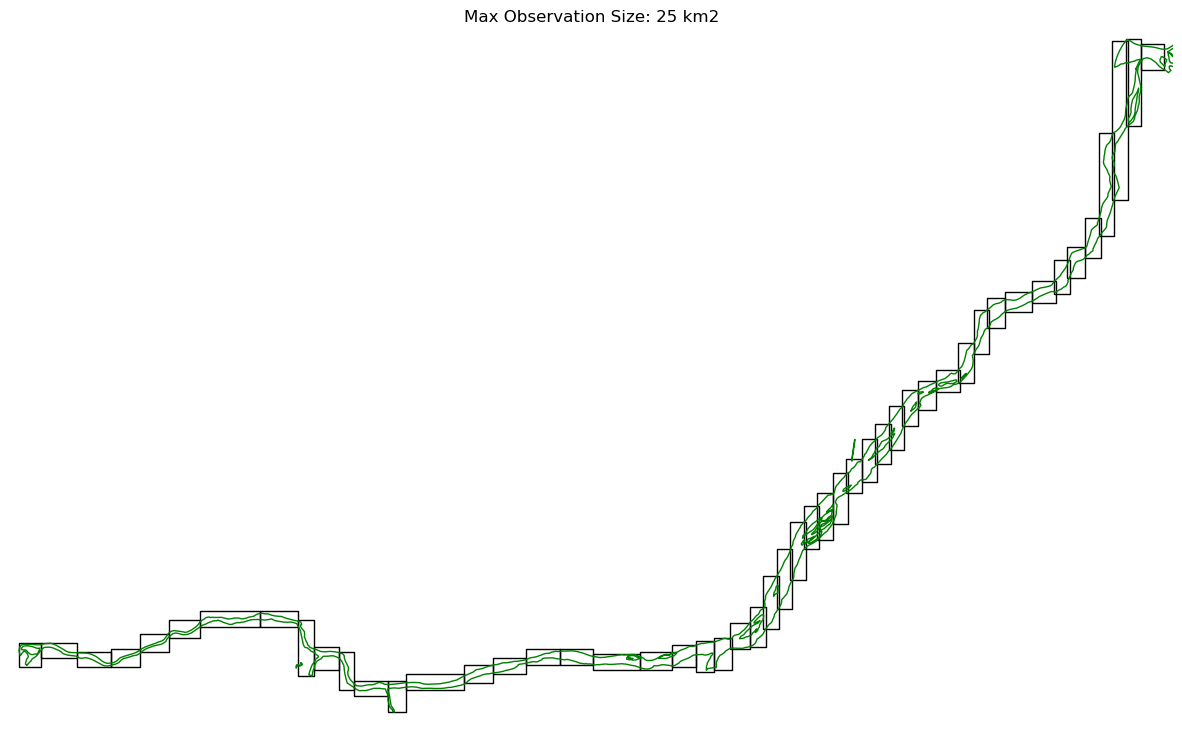

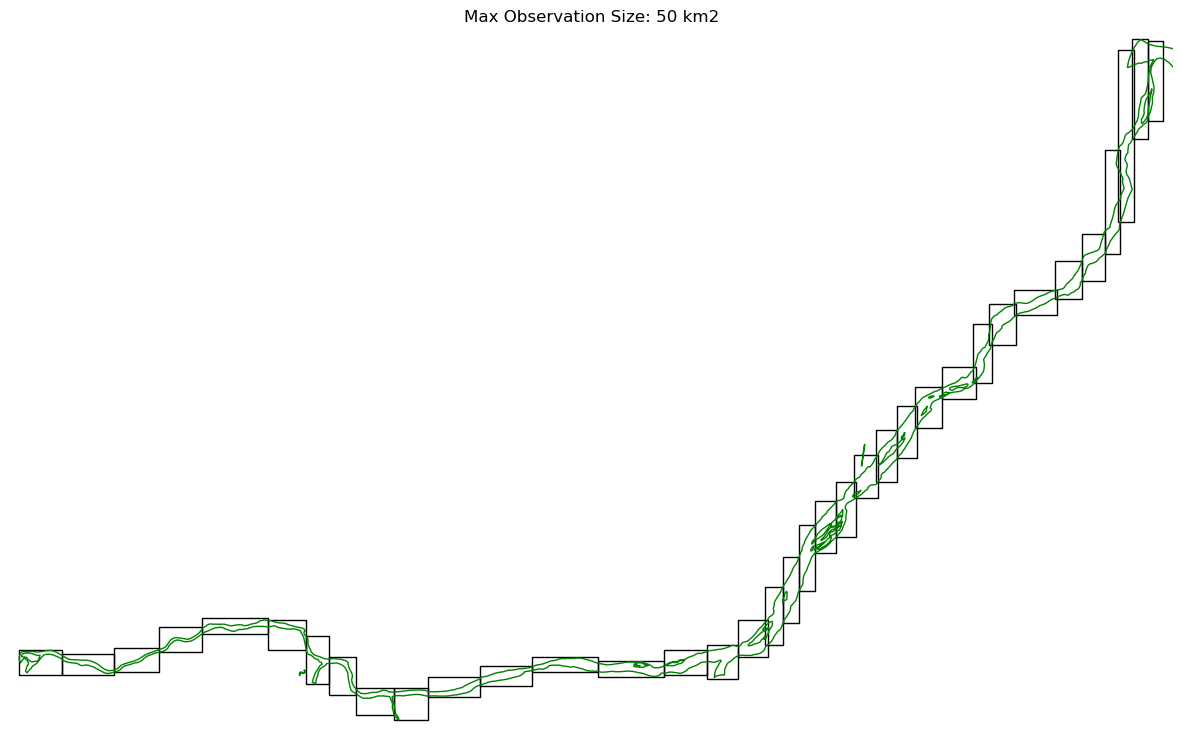

In [90]:
for area, p_df in [(10, polygons_10km2), 
                    (25, polygons_25km2), 
                   (50, polygons_50km2)]:
    sone_opt = gpd.GeoDataFrame(geometry = p_df)
    
    fig, ax = plt.subplots(figsize = (15, 10))

    minx, miny, maxx, maxy = sone_opt.total_bounds
#     fishnet_grid.plot(ax = ax, facecolor = 'None', edgecolor = 'red')
    sone_opt.plot(facecolor = 'None', ax = ax)
    sone_utm.plot(ax = ax, facecolor = 'None', edgecolor = 'green')

    plt.xlim(minx-2000, maxx+2000)
    plt.ylim(miny-2000, maxy+2000)
    plt.title(f"Max Observation Size: {area} km2")
    ax.axis('off')

In [ ]:
#### Closer look at 25 sq km 

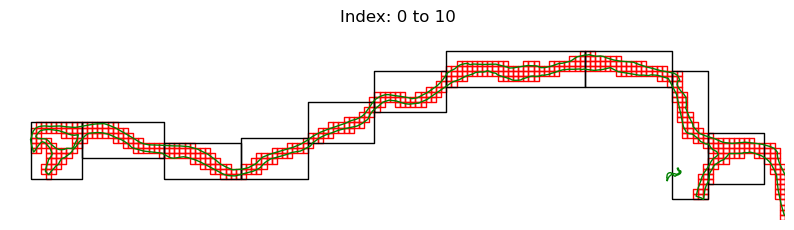

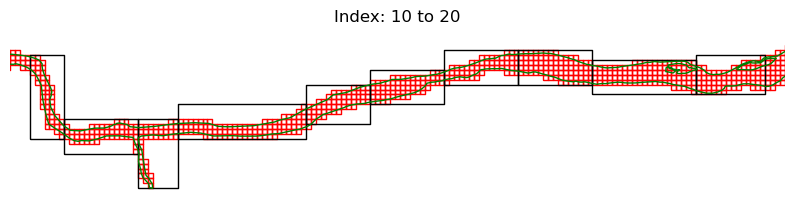

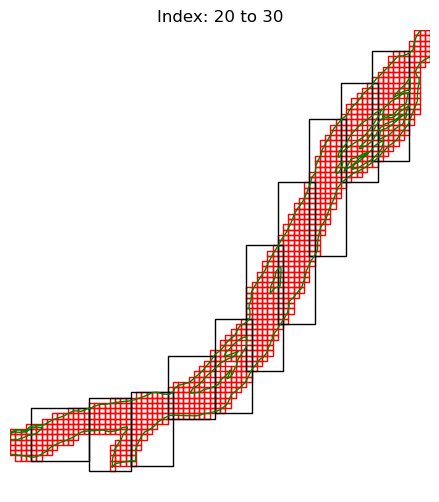

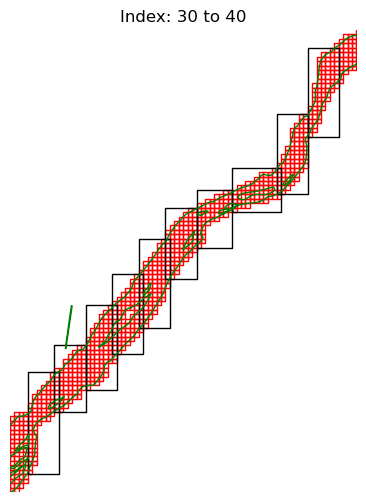

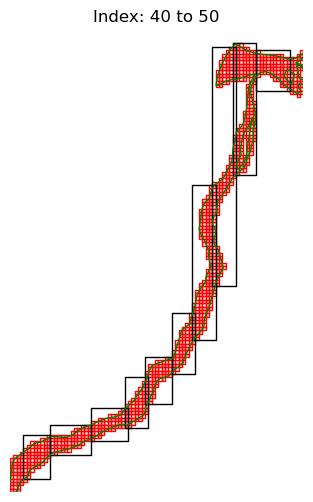

In [91]:
sone_opt = gpd.GeoDataFrame(geometry = polygons_25km2)

N_observations = len(sone_opt)

end_lower = int(np.floor(N_observations/10))*10 + 1
end_upper = int(np.ceil(N_observations/10))*10 + 1
vals = list(zip(range(0, end_lower, 10), 
    range(10, end_upper, 10)))


for start, end in vals:
    fig, ax = plt.subplots(figsize = (10, 6))
    plt_df = sone_opt[start:end]
    minx, miny, maxx, maxy = plt_df.total_bounds
    fishnet_grid.plot(ax = ax, facecolor = 'None', edgecolor = 'red')
    plt_df.plot(facecolor = 'None', ax = ax)
    sone_utm.plot(ax = ax, facecolor = 'None', edgecolor = 'green')

    plt.xlim(minx-2000, maxx+2000)
    plt.ylim(miny-2000, maxy+2000)
    ax.axis('off')
    plt.title(f"Index: {start} to {end}")
    plt.show()



In [82]:
#### Scrap

In [81]:
# #### Naive -- will generate many overlaps. 
# cells = []
# polygons = []
# add_geom = True

# new_minx = None
# new_miny = None

# geoms = fishnet_grid.geometry.values
# for geom in geoms:
    
# #     geom_minx, geom_miny, geom_maxx, geom_maxy = geom.bounds
    
# #     if (new_minx is not None) & (new_miny is not None):
# #         if geom_minx <
#     if len(cells) > 0:
#         tmp = gpd.GeoDataFrame(geometry = cells)
#         minx, miny, maxx, maxy = tmp.total_bounds
        
#         l = (maxx - minx)
#         w = (maxy - miny)
#         area =  l * w
        
#         if (area > min_area) & (l > min_length) & ( w > min_height):
#             polygon = Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny)])
#             polygons.append(polygon)
#             add_geom = False
#             cells = []
#     if add_geom:
#         cells.append(geom)
#     if len(cells) == 0:
#         add_geom = True
        
# tmp = gpd.GeoDataFrame(geometry = polygons)